## Dependencies

Due to this codebase being inherited from 2022, we have to install a previous version of torch due to torchtext being deprecated.

In [ ]:
!pip install --upgrade torch==2.3.0
!pip install --upgrade torchtext==0.18.0
!pip install --upgrade torchvision==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Shared codebase

The following defines useful methods, the definition of models to use and anything that is not subject to change.*italicized text*

In [ ]:
import torch


import time
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as torch_vocab
from torch.utils.data import DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.metrics import f1_score, precision_score, recall_score

def build_vocab_from_corpus(dataset, tokenizer):
    """
    Given a corpus, builds a Vocab object with tokenizer function.
    """
    counter = Counter()
    for _headline, _body, _ in dataset:
        counter.update(tokenizer(_headline + "\n\n" + _body))
    v = torch_vocab(counter, specials=["BOH", "EOH", "BOP", "EOP"])
    return v

def calculate_metrics(predictions, y_true):
    """
    A simple funcion that given predictions and the expected results
    will return the precision, recall and f1 (macro).
    """
    y_pred = predictions.argmax(dim=1)
    y_true = y_true.argmax(dim=1)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    return precision, recall, f1

def training_step(model, dataloader, optimizer, criterion, device):
    """
    Given a model, a dataloader, a optimizer and a criterion, it wil perform
    a training step in batches.
    """

    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    model.train()

    i = 0

    for labels, headlines, bodies in dataloader:
        i += 1
        # Move to device (usually GPU/TPU)
        labels = labels.to(device)
        headlines = headlines.to(device)
        bodies = bodies.to(device)
        # Reset gradients for previous steps
        optimizer.zero_grad()

        # Perform predictions
        predictions = model(headlines, bodies)

        # Criterion to define target
        loss = criterion(predictions, torch.argmax(labels, dim=1))

        # Metrics
        predictions = predictions.to('cpu')
        labels = labels.to('cpu')
        headlines = headlines.to('cpu')
        bodies = bodies.to('cpu')
        precision, recall, f1 = calculate_metrics(predictions, labels)

        # Gradients
        loss.backward()

        # Optimization
        optimizer.step()

        # Update metrics
        epoch_loss += loss.item()
        epoch_precision += precision
        epoch_recall += recall
        epoch_f1 += f1

    return epoch_loss / len(dataloader), epoch_precision / len(
        dataloader), epoch_recall / len(dataloader), epoch_f1 / len(dataloader)

def evaluate(model, dataloader, criterion):

    epoch_loss = 0
    epoch_precision = 0
    epoch_recall = 0
    epoch_f1 = 0

    model.eval()

    # Indicamos que ahora no guardaremos los gradientes
    with torch.no_grad():
        # Por cada batch
        for labels, headlines, bodies in dataloader:

            labels = labels.to(device)
            headlines = headlines.to(device)
            bodies = bodies.to(device)

            # Predecimos
            predictions = model(headlines, bodies)

            # Calculamos el Cross Entropy de las predicciones con respecto a las etiquetas reales
            loss = criterion(predictions, torch.argmax(labels, dim=1))

            predictions = predictions.to('cpu')
            labels = labels.to('cpu')
            headlines = headlines.to('cpu')
            bodies = bodies.to('cpu')

            # Calculamos las métricas
            precision, recall, f1 = calculate_metrics(predictions, labels)

            # Actualizamos el loss y las métricas
            epoch_loss += loss.item()
            epoch_precision += precision
            epoch_recall += recall
            epoch_f1 += f1

    return epoch_loss / len(dataloader), epoch_precision / len(
        dataloader), epoch_recall / len(dataloader), epoch_f1 / len(dataloader)


def run_experiment(model, model_name, criterion, train_dataloader, valid_dataloader, n_epochs, device):

  model.to(device)
  criterion.to(device)
  best_valid_loss = float('inf')

  for epoch in range(n_epochs):

      start_time = time.time()

      # Recuerdo: train_iterator y valid_iterator contienen el dataset dividido en batches.

      # Entrenar
      train_loss, train_precision, train_recall, train_f1 = training_step(
            model, train_dataloader, optimizer, criterion, device)

      print("Finishing training epoch")

        # Evaluar (valid = validación)
      valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(
            model, valid_dataloader, criterion)

        #print("Finishing validation epoch")
      end_time = time.time()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Si obtuvimos mejores resultados, guardamos este modelo en el almacenamiento (para poder cargarlo luego)
        # Si detienen el entrenamiento prematuramente, pueden cargar el modelo en el siguiente recuadro de código.
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), '{}.pt'.format(model_name))
        # Si ya no mejoramos el loss de validación, terminamos de entrenar.

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(
            f'\tTrain Loss: {train_loss:.3f} | Train f1: {train_f1:.2f} | Train precision: {train_precision:.2f} | Train recall: {train_recall:.2f}'
        )
      print(
            f'\t Val. Loss: {valid_loss:.3f} |  Val. f1: {valid_f1:.2f} |  Val. precision: {valid_precision:.2f} | Val. recall: {valid_recall:.2f}'
        )


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


class FakeNewsDataset(Dataset):
    """
    Dataset class for Clickbait Webis 20217 Dataset.
    Assumes data has already been preprocessed and has a format
    (headline, body, truthClass).
    """
    def __init__(self, path='data/clickbait', split='train'):
        if split not in ['train', 'test', 'valid']:
            raise ValueError(f'Dataset {split} not found, it must be train, valid or test')
        self.split = split
        dataset = pd.read_csv(f'{path}/{split}.csv')
        self.headlines = list(dataset['headline'])
        self.bodies = list(dataset['body'])
        self.labels = list(dataset['label'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.headlines[idx], self.bodies[idx], self.labels[idx]


class ClickbaitDataset(Dataset):
    """
    Dataset class for Clickbait Webis 20217 Dataset.
    Assumes data has already been preprocessed and has a format
    (headline, body, truthClass).
    """
    def __init__(self, path='data/clickbait', split='train'):
        if split not in ['train', 'test', 'valid']:
            raise ValueError(f'Dataset {split} not found, it must be train, valid or test')
        self.split = split
        if split == 'valid':
            split = 'validation'
        dataset = pd.read_csv(f'{path}/{split}/{split}.csv')
        self.headlines = list(dataset['headline'])
        self.bodies = list(dataset['body'])
        self.labels = list(dataset['truthClass'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.headlines[idx], self.bodies[idx], self.labels[idx]


class IncongruenceDataset(Dataset):
    """
    Dataset for FNC-1 Dataset.
    Assumes data has already been preprocessed and
    has a format (headline, body, labels)
    """

    def __init__(self, path='../data/fnc-1', split='train'):
        if split not in ['train', 'test', 'valid']:
            raise ValueError(f'Dataset {split} not found, it must be train, valid or test')
        self.split= split
        dataset = pd.read_csv(f'{path}/{split}.csv')
        self.headlines = list(dataset['headline'])
        self.bodies = list(dataset['body'])
        self.labels = list(dataset['label'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.headlines[idx], self.bodies[idx], self.labels[idx])


class BiDualEncoder(nn.Module):

    def __init__(
            self, vocab_size,
            vectors=None,
            embed_dim=300,
            hidden_dim=128,
            hidden_layers=2,
            output_dim=2,
            freeze_embed=True,
            dropout=0.3,
        ):

        super().__init__()

        self.hidden_dim = hidden_dim

        # Shared embedding layer
        if vectors is not None:
          self.embedding_layer = nn.Embedding(vocab_size, embed_dim).from_pretrained(
              vectors,
              freeze=freeze_embed
          )
        else:
          self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # Encoders
        self.headline_lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=hidden_layers, bidirectional=True)
        self.body_lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=hidden_layers, bidirectional=True)

        # Prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, headline, body):

        # Representations
        headline_embedding = self.embedding_layer(headline)
        body_embedding = self.embedding_layer(body)


        # Headline latent representation
        headline_lstm, _ = self.headline_lstm(headline_embedding)

        # Body latent representation
        body_lstm, _ = self.body_lstm(body_embedding)

        # Average latest output (bidirectional)
        # This is performerd taking the last
        output_lstm = (headline_lstm[-1,:,:self.hidden_dim] + body_lstm[-1,:,:self.hidden_dim]) / 2
        output = self.fc(self.dropout(output_lstm))
        return output


class BiConditionalDualEncoder(nn.Module):

    def __init__(
            self, vocab_size,
            vectors=None,
            embed_dim=300,
            hidden_dim=128,
            hidden_layers=2,
            output_dim=2,
            freeze_embed=True,
            dropout=0.3,
        ):

        super().__init__()

        self.hidden_dim = hidden_dim

        # Shared embedding layer
        if vectors is not None:
          self.embedding_layer = nn.Embedding(vocab_size, embed_dim).from_pretrained(
              vectors,
              freeze=freeze_embed
          )
        else:
          self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # Encoders
        self.headline_lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=hidden_layers, bidirectional=True, dropout=dropout)
        self.body_lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=hidden_layers, bidirectional=True, dropout=dropout)

        # Prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, headline, body):

        # Representations
        headline_embedding = self.embedding_layer(headline)
        body_embedding = self.embedding_layer(body)

        # Headline latent representation
        _, (h_hidden, h_cell) = self.headline_lstm(headline_embedding)

        # Body latent representation
        body_lstm, _ = self.body_lstm(body_embedding, (h_hidden, h_cell))

        # Average outputs of body
        output_lstm = (body_lstm[-1,:,:self.hidden_dim] + body_lstm[-1,:,self.hidden_dim:]) / 2
        output = self.fc(self.dropout(output_lstm))
        return output


class LTSM_Encoder(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_layers, padding_idx, vectors, bidirectional=False, dropout=0.3):
        super().__init__()
        # Embedding layer
        self.embed_layer = nn.Embedding(input_dim, embedding_dim).from_pretrained(vectors, freeze=True)
        # LSTM layer
        self.hidden_dim = hidden_dim
        self.lstm_headline = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0)
        self.lstm_body = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0)
        # Output layer
        self.fc = nn.Linear(hidden_dim * 4 if bidirectional else hidden_dim * 2, output_dim)
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, headline, body):
        # Embed text
        headline_embed = self.embed_layer(headline)
        body_embed = self.embed_layer(body)
        # LSTM layer
        outputs_heads, (hidden_heads, cell_heads) = self.lstm_headline(headline_embed)
        outputs_bodies, (hidden_bodies, cell_bodies) = self.lstm_body(body_embed)
        outputs_heads = outputs_heads[-1]
        outputs_bodies = outputs_bodies[-1]
        outputs = torch.cat((outputs_heads, outputs_bodies), 1)
        # Make predictions
        predictions = self.fc(self.dropout(outputs))
        return predictions

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

## Tokenization and collation

While ideally this code is subject to little changes, we prefer to separate it from the shared and static codebase.



In [ ]:
import re
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')

vocab_transform = lambda x: [vocab[token] if token in vocab else 0 for token in tokenizer(x)]

tensor_transform = lambda x: torch.tensor(x)

def label_transform(label):
    if label == 'agree':
        return [1, 0, 0, 0]
    elif label == 'disagree':
        return [0, 1, 0, 0]
    elif label == 'discuss':
        return [0, 0, 1, 0]
    elif label == 'unrelated':
        return [0, 0, 0, 1]

def collate_batch(batch):
    articles, headlines, labels = [], [], []
    for (_headline, _body, _label) in batch:
        # Transform the headline
        _headline = tensor_transform(vocab_transform(_headline))
        _body = tensor_transform(vocab_transform(_body)[:300])
        headlines.append(_headline)
        articles.append(_body)
        labels.append(label_transform(_label))
    # Transform labels to tensor and add padding to articles
    labels = torch.tensor(labels)
    headlines = pad_sequence(headlines)
    articles = pad_sequence(articles)

    pad = articles.shape[0] - headlines.shape[0]
    headlines = F.pad(headlines, pad=(0,0, 0, pad), value=0)
    # Transform labels to tensor and add padding to articles
    return labels, headlines, articles

In [ ]:
!pip install transformers &> /dev/null
!pip install sentencepiece &> /dev/null
!pip install torchmetrics & > /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 17.8 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clickbait_test_dataset = ClickbaitDataset(path="/content/drive/MyDrive/Tesis/Tesis/clickbait", split="test")
fnc_test_dataset = FakeNewsDataset(path="/content/drive/MyDrive/Tesis/Tesis/incongruence/fnc-1/original/two", split="test")
isot_test_dataset = FakeNewsDataset(path="/content/drive/MyDrive/Tesis/Tesis/ISOTFakeNews/clean", split="test")

In [ ]:
def collate_batch(batch):

    token_ids, mask_ids, segment_ids, labels = [], [], [], []

    for (_headline, _body, _label) in batch:
        _headline_id = tokenizer.encode(_headline[:512], add_special_tokens=False)
        _headline_len = len(_headline_id)
        _body_id = tokenizer.encode(_body[:(512 - _headline_len - 3)], add_special_tokens=False)
        _pair_token_ids = [tokenizer.cls_token_id] + _body_id + [tokenizer.sep_token_id] + _headline_id + [tokenizer.sep_token_id]

        _body_len = len(_body_id)

        _segment_ids = torch.tensor([0] * (_body_len + 2) + [1] * (_headline_len + 1))
        _attn_mask_ids = torch.tensor([1] * (_body_len + _headline_len + 3))

        token_ids.append(torch.tensor(_pair_token_ids))
        segment_ids.append(_segment_ids)
        mask_ids.append(_attn_mask_ids)

        labels.append(label_dict[_label])

    token_ids = pad_sequence(token_ids, batch_first=True)
    segment_ids = pad_sequence(segment_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    labels = torch.tensor(labels)

    return token_ids, mask_ids, segment_ids, labels


In [ ]:
import time
from torchmetrics import F1Score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


f1_score = F1Score(task="binary", average='macro')
f1_score = f1_score.to(device)

def evaluate_bert(model, test_dataloader):
  total_test_acc  = 0
  total_test_loss = 0
  with torch.no_grad():
      y_preds = torch.tensor(()).int().to(device)
      y_tests = torch.tensor(()).int().to(device)
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(test_dataloader):
        #optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)

        loss, prediction = model(pair_token_ids,
                             token_type_ids=seg_ids,
                             attention_mask=mask_ids,
                             labels=labels).values()

        y_pred = torch.log_softmax(prediction, dim=1).argmax(dim=1)
        y_preds = torch.cat([y_preds, y_pred])
        y_tests = torch.cat([y_tests, labels])

        total_test_loss += loss.item()
        #total_test_acc  += acc.item()

      test_loss = total_test_loss / len(test_dataloader)
      test_acc = total_test_acc / len(test_dataloader)
      test_f1 = f1_score(y_preds, y_tests)
      print(f'Test Loss: {test_loss:.3f} | Test f1: {test_f1:.3f}')
      return y_preds, y_tests


def generate_confusion_matrix(y_preds, y_tests, group_names=["True Neg", "False Pos","False Neg","True Pos"]):
  y_preds = y_preds.cpu()
  y_tests = y_tests.cpu()
  cf_matrix = confusion_matrix(y_tests, y_preds)
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/len(y_preds)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Evaluate clickbait model

# BERT


In [ ]:
from transformers import BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Tesis/click_model.pt', weights_only=True))
model.eval()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Clickbait


Test Loss: 0.420 | Test f1: 0.885


<Axes: >

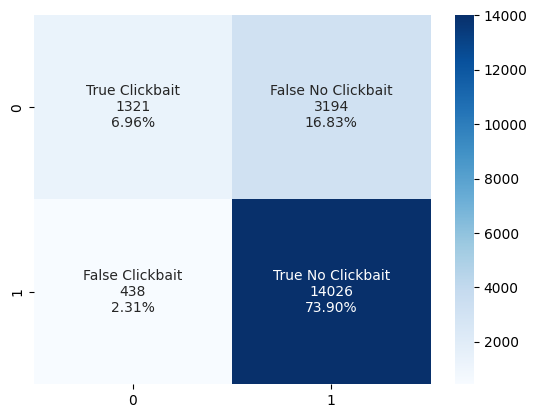

In [ ]:
label_dict = {
    'clickbait': 0,
    'no-clickbait': 1,
}

clickbait_dataloader = DataLoader(list(clickbait_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

clickbait_preds_by_clickait, y_tests = evaluate_bert(model, clickbait_dataloader)


In [ ]:
generate_confusion_matrix(clickbait_preds_by_clickait, y_tests, ["True Clickbait", "False No Clickbait", "False Clickbait", "True No Clickbait"])

In [ ]:
label_dict = {
    'true': 0,
    'fake': 1,
}

isot_dataloader = DataLoader(list(isot_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

isot_preds_by_clickbait, y_tests = evaluate_bert(model, isot_dataloader)

Test Loss: 1.528 | Test f1: 0.665


<Axes: >

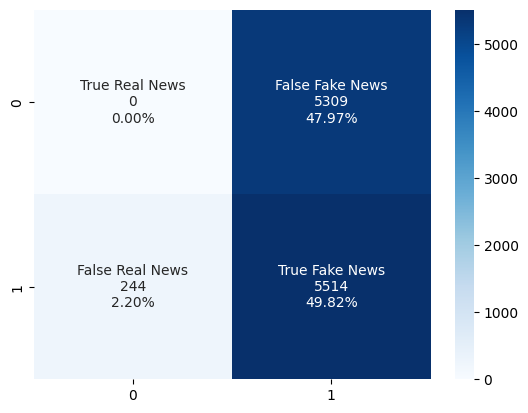

In [ ]:
generate_confusion_matrix(isot_preds_by_clickbait, y_tests, ["True Real News", "False Fake News", "False Real News", "True Fake News"])

In [ ]:
label_dict = {
    'agree': 1,
    'discuss': 1,
    'disagree': 0,
    'unrelated': 0,
}

fnc_dataloader = DataLoader(list(fnc_test_dataset), batch_size=32, shuffle=False,
                                collate_fn=collate_batch)

fnc_preds_by_clickbait, y_tests = evaluate_bert(model, fnc_dataloader)


Test Loss: 0.356 | Test f1: 0.940


<Axes: >

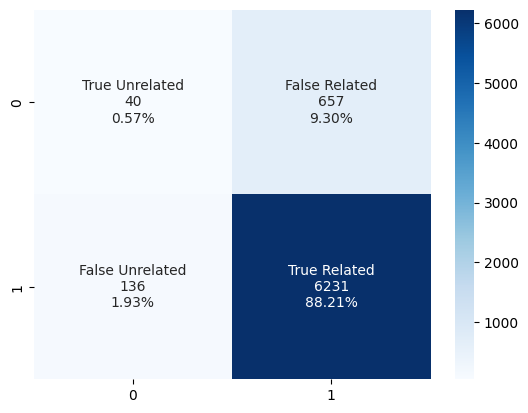

In [ ]:
generate_confusion_matrix(fnc_preds_by_clickbait, y_tests, ["True Unrelated", "False Related", "False Unrelated", "True Related"])

## ISOT

In [ ]:
from transformers import BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Tesis/bert-isort.pt', weights_only=True))
model.eval()
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
label_dict = {
    'true': 0,
    'fake': 1,
}

isot_dataloader = DataLoader(list(isot_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

isot_preds_by_isot, y_tests = evaluate_bert(model, isot_dataloader)

Test Loss: 0.002 | Test f1: 1.000


<Axes: >

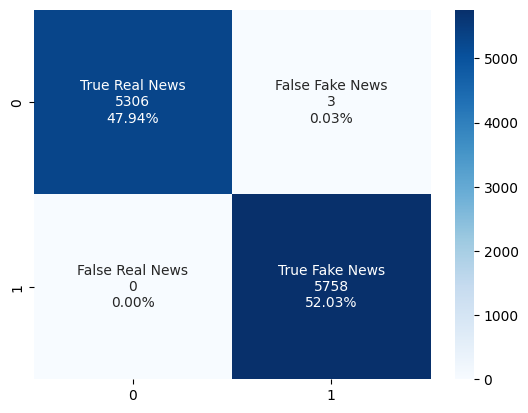

In [ ]:
generate_confusion_matrix(isot_preds_by_isot, y_tests, ["True Real News", "False Fake News", "False Real News", "True Fake News"])

In [ ]:
label_dict = {
    'no-clickbait': 0,
    'clickbait': 1,
}

isot_dataloader = DataLoader(list(clickbait_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

clickbait_preds_by_isot, y_tests = evaluate_bert(model, isot_dataloader)


Test Loss: 5.396 | Test f1: 0.390


<Axes: >

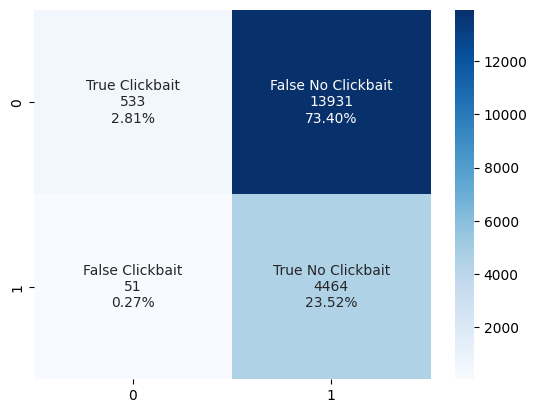

In [ ]:
generate_confusion_matrix(clickbait_preds_by_isot, y_tests, ["True Clickbait", "False No Clickbait", "False Clickbait", "True No Clickbait"])

In [ ]:
label_dict = {
    'agree': 1,
    'discuss': 1,
    'disagree': 0,
    'unrelated': 0,
}

fnc_dataloader = DataLoader(list(fnc_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

fnc_preds_by_isot, y_tests = evaluate_bert(model, fnc_dataloader)


Test Loss: 1.176 | Test f1: 0.925


<Axes: >

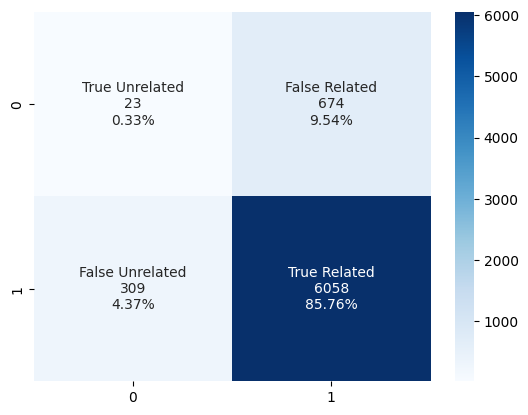

In [ ]:
generate_confusion_matrix(fnc_preds_by_isot, y_tests, ["True Unrelated", "False Related", "False Unrelated", "True Related"])

## FNC

In [ ]:
from transformers import BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Tesis/bert-fnc-2class.pt', weights_only=True))
model.eval()
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
label_dict = {
    'agree': 0,
    'disagree': 1,
    'discuss': 0,
}

fnc_dataloader = DataLoader(list(fnc_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

fnc_preds_by_fnc, y_tests = evaluate_bert(model, fnc_dataloader)

Test Loss: 0.581 | Test f1: 0.302


<Axes: >

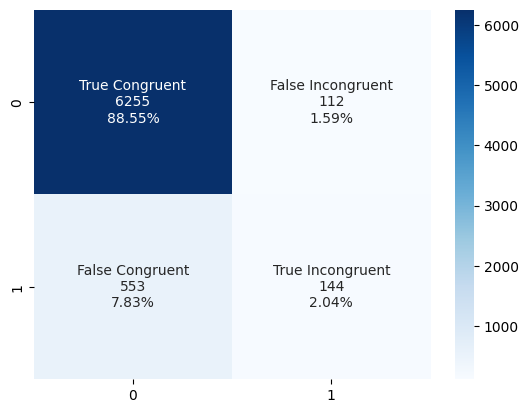

In [ ]:
generate_confusion_matrix(fnc_preds_by_fnc, y_tests, ["True Congruent", "False Incongruent", "False Congruent", "True Incongruent"])

In [ ]:
label_dict = {
    'true': 0,
    'fake': 1,
}

isot_dataloader = DataLoader(list(isot_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

isot_preds_by_fnc, y_tests = evaluate_bert(model, isot_dataloader)


Test Loss: 3.517 | Test f1: 0.095


<Axes: >

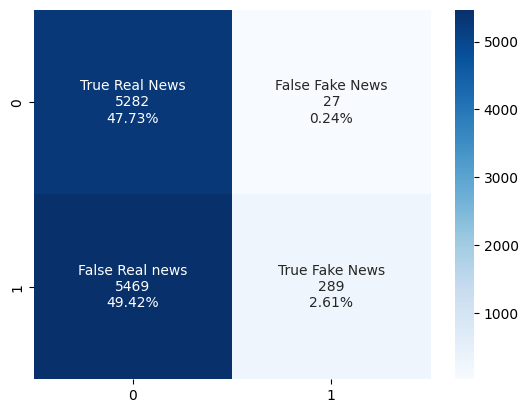

In [ ]:
generate_confusion_matrix(isot_preds_by_fnc, y_tests, ["True Real News", "False Fake News", "False Real news", "True Fake News"])

Test Loss: 1.850 | Test f1: 0.042


<Axes: >

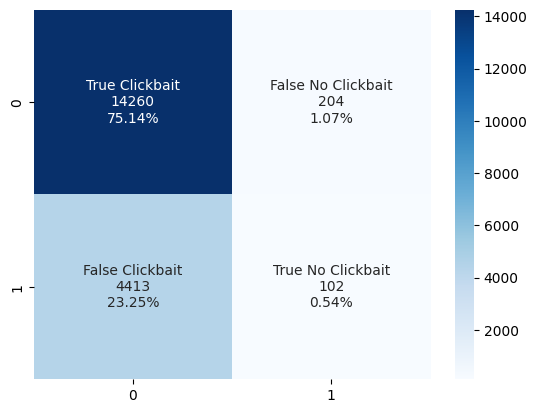

In [ ]:
label_dict = {
    'no-clickbait': 0,
    'clickbait': 1,
}

clickbait_dataloader = DataLoader(list(clickbait_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)

clickbait_preds_by_fnc, y_tests = evaluate_bert(model, clickbait_dataloader)
generate_confusion_matrix(clickbait_preds_by_fnc, y_tests, ["True No Clickbait", "False No Clickbait", "False Clickbait", "True No Clickbait"])

<Axes: >

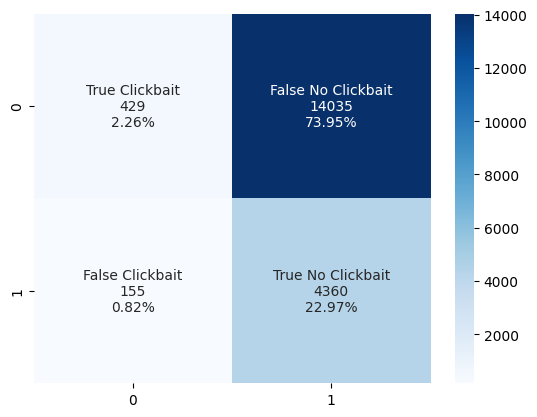

In [ ]:
generate_confusion_matrix(clickbait_preds_by_isot, y_tests, ["True Clickbait", "False No Clickbait", "False Clickbait", "True No Clickbait"])

## FNC (4 classes)

In [ ]:
from transformers import BertForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.load_state_dict(torch.load('/content/drive/MyDrive/Tesis/bert-fnc.pt', weights_only=True))
model.eval()
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
fnc_test_dataset = FakeNewsDataset(path="/content/drive/MyDrive/Tesis/Tesis/incongruence/fnc-1/original/", split="test")

label_dict = {
    'agree': 0,
    'disagree': 1,
    'discuss': 2,
    'unrelated': 3,
}

fnc_dataloader = DataLoader(list(fnc_test_dataset), batch_size=32, shuffle=True,
                                collate_fn=collate_batch)



In [ ]:
f1_score = F1Score(task="multiclass", num_classes=4, average='macro')
f1_score = f1_score.to(device)

In [ ]:
fnc4_by_fnc4, y_tests = evaluate_bert(model, fnc_dataloader)

Test Loss: 0.382 | Test f1: 0.711


In [ ]:
cf = confusion_matrix(y_tests.cpu(), fnc4_by_fnc4.cpu())
cf

array([[ 1137,    47,   686,    33],
       [  157,   192,   306,    42],
       [  324,    51,  4003,    86],
       [   16,     2,   245, 18086]])

<Axes: >

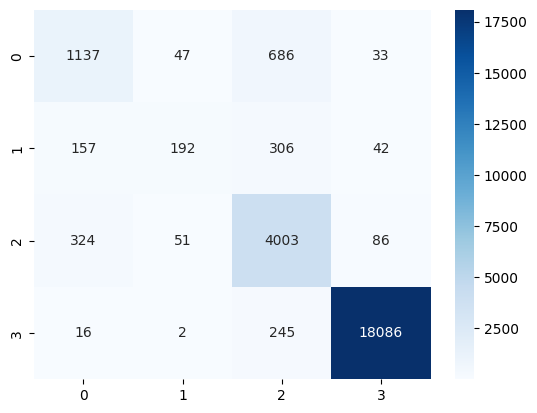

In [ ]:
sns.heatmap(cf, annot=True, fmt='', cmap='Blues')

In [ ]:
def generate_fnc_confusion_matrix(y_preds, y_tests):
  y_preds = y_preds.cpu()
  y_tests = y_tests.cpu()
  cf_matrix = confusion_matrix(y_tests, y_preds)
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/len(y_preds)]
  group_names = ["True Agree", "False Disagree", "False Discuss", "False Unrelated", "False Agree", "True Disagree", "False Discuss", "False Unrelated", "False Agree", "False Disagree", "True Discuss", "False Unrelated", "False Agree", "False Disagree", "False Discuss", "True Unrelated"]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(4,4)
  return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

<Axes: >

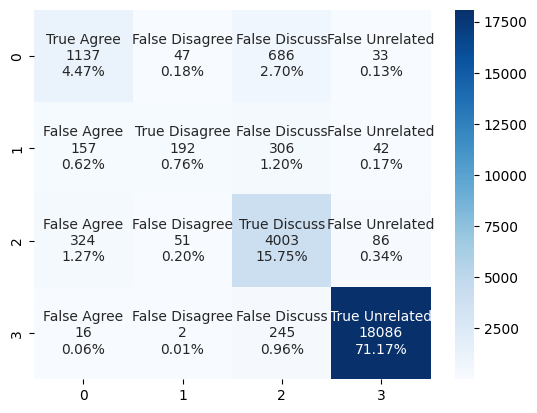

In [ ]:
generate_fnc_confusion_matrix(fnc4_by_fnc4.cpu(), y_tests.cpu())

In [ ]:
label_dict = {
    'clickbait': 2,
    'no-clickbait': 0,
}

clickbait_by_fnc4, y_tests = evaluate_bert(model, clickbait_dataloader)

Test Loss: 2.459 | Test f1: 0.229


<Axes: >

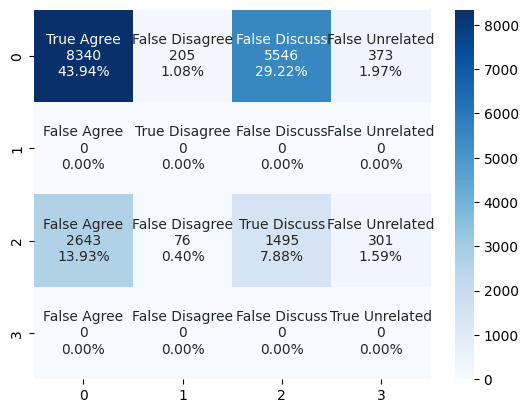

In [ ]:
generate_fnc_confusion_matrix(clickbait_by_fnc4.cpu(), y_tests.cpu())